In [1]:
import rasterio
import os
import numpy as np
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import os
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:

data_dir = "data/raster"
# Input raster 
fp = os.path.join(os.getcwd(),data_dir, "DSM_Mosaic.tif")
print (fp)

# Output raster
out_tif = os.path.join(data_dir, "Sansa.tif")

/home/matteo/Projects/DistrictPV/data/raster/DSM_Mosaic.tif


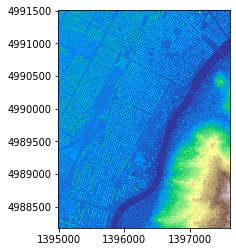

In [3]:
# Read the data
data = rasterio.open(fp)
show(data, cmap='terrain')

In [4]:
geo = gpd.read_file('data/turin_districts/turin_districts.shp')
geo=geo[geo.DENOM=='San Salvario']
geo

,ID_QUART,DENOM,geometry
1,2,San Salvario,"POLYGON ((1395047.711 4988754.874, 1395057.312..."


In [5]:
#Reporject polygon in the correct system
print(data.crs.data)
geo.crs={'init':'epsg:3003'}
geo = geo.to_crs(crs=data.crs.data)
print(geo.crs)

{'init': 'epsg:3003'}
{'init': 'epsg:3003'}


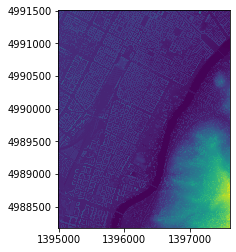

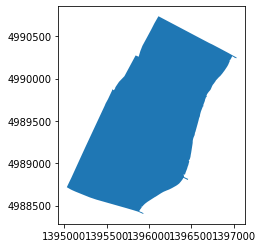

In [6]:
show(data)
geo.plot()

In [7]:
# Clip the raster with Polygon
out_img, out_transform = mask(dataset=data, shapes=geo.geometry, crop=True)

In [8]:
# Copy the metadata
out_meta = data.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 5248, 'height': 6660, 'count': 1, 'crs': CRS.from_epsg(3003), 'transform': Affine(0.5, 0.0, 1394991.0,
       0.0, -0.5, 4991504.0)}


In [9]:
# Parse EPSG code
epsg_code = int(data.crs.data['init'][5:])
print(epsg_code)

3003


In [10]:
#Update metadata
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform}
                         )

In [11]:
#Save clipped file
with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)

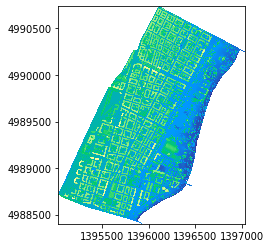

In [12]:
# Open the clipped raster file
clipped = rasterio.open(out_tif)

# Visualize
show(clipped, cmap='terrain')

In [122]:
#Reproject
from rasterio.warp import calculate_default_transform, reproject, Resampling
out_tif_4326 = os.path.join(data_dir, "Sansa_4326.tif")
src=clipped
dst_crs = 'EPSG:4326'
transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
kwargs = src.meta.copy()
kwargs.update({
    'crs': dst_crs,
    'transform': transform,
    'width': width,
    'height': height
})
with rasterio.open(out_tif_4326, 'w', **kwargs) as dst:
    for i in range(1, src.count + 1):
        reproject(
            source=rasterio.band(src, i),
            destination=rasterio.band(dst, i),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest)

NameError: name 'clipped' is not defined

In [123]:
#f to calculate the gradient of the raster image
def slope_gradient(z):
    """
    Calculate absolute slope gradient elevation array.
    """
    x, y = np.gradient(z)  
    slope = np.sqrt(x*x + y*y)
    return slope


In [124]:
a=slope_gradient(clipped.read(1))
plt.imshow(a, vmin=0.0, vmax=1.0, cmap='pink')

NameError: name 'clipped' is not defined

In [125]:
def aspect(z):
    """Calculate aspect from DEM."""
    x, y = np.gradient(z)
    return np.arctan2(-x, y)

In [126]:
a=aspect(clipped.read(1))
plt.imshow(a, vmin=0.0, vmax=1.0, cmap='pink')

NameError: name 'clipped' is not defined

In [127]:
#processing
import gdal

In [128]:
gdal.DEMProcessing('data/raster/slope.tif', out_tif, 'slope')
slope=rasterio.open('data/raster/slope.tif')
show(slope)

ValueError: Received a NULL pointer.

In [129]:
gdal.DEMProcessing('data/raster/aspect.tif', out_tif, 'aspect')
aspect=rasterio.open('data/raster/aspect.tif')
show(aspect)

ValueError: Received a NULL pointer.

In [130]:
suitable_slope=(slope.read(1)>15) & (slope.read(1)<36)
suitable_aspect=(aspect.read(1)>240) & (aspect.read(1)<300)
suitable_area=suitable_slope & suitable_aspect
show(suitable_area)

NameError: name 'slope' is not defined

In [131]:
suitable_area=suitable_area.astype(int)


NameError: name 'suitable_area' is not defined

In [132]:
mask = suitable_area != 0
results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            rasterio.features.shapes(suitable_area.astype('int16'),transform=clipped.transform, mask=mask)))


NameError: name 'suitable_area' is not defined

In [133]:
results

NameError: name 'results' is not defined

In [134]:

geoms = list(results)

NameError: name 'results' is not defined

In [135]:
import geopandas as gpd
suitarea  = gpd.GeoDataFrame.from_features(geoms)

NameError: name 'geoms' is not defined

In [136]:
suitarea.crs=clipped.crs

NameError: name 'clipped' is not defined

In [137]:
suitarea.crs

NameError: name 'suitarea' is not defined

In [138]:
suitarea=suitarea[suitarea.raster_val!=0]
suitarea.to_crs(epsg='3003')

NameError: name 'suitarea' is not defined

In [139]:
suitarea.plot()

NameError: name 'suitarea' is not defined

In [140]:
from rasterstats import gen_zonal_stats,zonal_stats

In [141]:
# Read the raster values
array = slope.read(1)

# Get the affine
affine = clipped.transform

NameError: name 'slope' is not defined

In [142]:
#slp=zonal_stats(suitarea, array, affine=affine, stats=['mean', 'count'],geojson_out=True)

#rasterValue=aspect.read(1)
#asp=zonal_stats(suitarea, rasterValue, affine=affine, stats=['mean', 'count'],geojson_out=True)

In [143]:
#suitable_area=gpd.GeoDataFrame.from_features(slp)
#suitable_area_aspect=gpd.GeoDataFrame.from_features(asp)

In [144]:
#suitable_area.crs={'init':'epsg:3003'}
#suitable_area.to_crs(epsg='4326')
#suitable_area_aspect.crs={'init':'epsg:3003'}
#suitable_area_aspect.to_crs(epsg='4326')

In [145]:
suitable_area['Area_real']=suitable_area['count']*(0.5*0.5)/np.cos(np.radians(suitable_area['mean']))
suitable_area['Aspect']=suitable_area_aspect['mean']

NameError: name 'suitable_area_aspect' is not defined

In [146]:
#suitable_area=suitable_area[suitable_area['Area_real']>20]

In [147]:
#suitable_area.to_file('data/suit_sansa.shp')

In [148]:
suitable_area=gpd.read_file('data/suit_sansa.shp')

DriverError: data/suit_sansa.shp: No such file or directory

In [149]:
#filter

suitable_area=suitable_area[suitable_area['Area_real']>20]

NameError: name 'suitable_area' is not defined

In [150]:
print(type(suitable_area))
print(suitable_area)

NameError: name 'suitable_area' is not defined

In [151]:
suitable_area.crs

NameError: name 'suitable_area' is not defined

In [152]:
from shapely.geometry import Polygon
import shapely

In [153]:
suitable_area.iloc[0]

NameError: name 'suitable_area' is not defined

In [154]:
#pol=Polygon([(1396106,4990688), (1396106, 4990695.7), (1396107, 4990695.7), (1396107, 4990688)])
roof=suitable_area.iloc[0]['geometry']
roofCenter=roof.centroid
rotatedRoof=shapely.affinity.rotate(roof,suitable_area.iloc[0]['Aspect'],origin=roofCenter)
_boundingBox=rotatedRoof.envelope
boundingBox=shapely.affinity.rotate(_boundingBox,360-suitable_area.iloc[0]['Aspect'],origin=roofCenter)
#boundingBox=shapely.affinity.rotate(boundingBox,360-suitable_area.iloc[0]['Aspect'],origin=roofCentre)

NameError: name 'suitable_area' is not defined

In [155]:
#Panel creation
xs,ys=_boundingBox.exterior.xy
startX=xs[0]
startY=ys[0]
panelW=0.8
panelH=1.2
_panel=Polygon([(startX,startY),(startX,startY+panelH),(startX+panelW,startY+panelH),(startX+panelW,startY)])
panel=shapely.affinity.rotate(_panel,360-suitable_area.iloc[0]['Aspect'],origin=roofCenter)

NameError: name '_boundingBox' is not defined

In [156]:
gpd.GeoSeries([panel,rotatedRoof]).plot(cmap='tab10')

NameError: name 'panel' is not defined

In [157]:
centroid=geo.to_crs(epsg='4326').centroid
centroid

NameError: name 'geo' is not defined

In [158]:
import json
#Select a roof
a=json.loads(suitable_area.to_crs(epsg='4326').to_json())
tetto={'type':'FeatureCollection'}
tetto['features']=[a['features'][0]]

#Bounding box to json
temp=gpd.GeoSeries([boundingBox])
temp.crs={'init':'epsg:3003'}

#Panel to json
temp2=gpd.GeoSeries([panel])
temp2.crs={'init':'epsg:3003'}
panel=json.loads(temp2.to_crs(epsg='4326').to_json())
#print(json.dumps(tetto,indent=4))

#print(a.keys())
#print(tetto.keys())
#print(a['type'])
#print(a['features'][0])
#print(b['features'])

NameError: name 'suitable_area' is not defined

In [159]:
import folium
m = folium.Map([centroid.y, centroid.x],crs='EPSG4326', zoom_start=15, tiles="OpenStreetMap")
folium.GeoJson(a,name='suitable_area').add_to(m)
folium.GeoJson(tetto,name='roof1').add_to(m)
folium.GeoJson(panel,name='panel').add_to(m)
folium.raster_layers.WmsTileLayer(
    url='http://niger3.csi.it/mapproxy/service',
    name='ortofoto',
    fmt='image/png',
    layers='regp_agea_2015',
    transparent=True,
    overlay=True,
    control=True,
).add_to(m)

folium.LayerControl().add_to(m)
m

NameError: name 'centroid' is not defined

In [160]:
index=0
roof=suitable_area.iloc[index]['geometry']
def detectAvailableSurface(roof,IndexError):
    roofCenter=roof.centroid
    rotatedRoof=shapely.affinity.rotate(roof,suitable_area.iloc[index]['Aspect'],origin=roofCenter)
    _boundingBox=rotatedRoof.envelope
    boundingBox=shapely.affinity.rotate(_boundingBox,360-suitable_area.iloc[index]['Aspect'],origin=roofCenter)
    xs,ys=_boundingBox.exterior.xy

    startX=xs[0]
    startY=ys[0]
    endX=xs[1]
    endY=ys[2]

    panelW=0.8
    panelH=1.2
    actualX=startX
    actualY=startY
    availablePositions=gpd.GeoDataFrame()
    dx=0.5
    dy=0.5
    panels=[]
    while actualX+panelW<endX:
        while actualY+panelH<endY:
            _panel=Polygon([(actualX,actualY),(actualX,actualY+panelH),(actualX+panelW,actualY+panelH),(actualX+panelW,actualY)])
            panel=shapely.affinity.rotate(_panel,360-suitable_area.iloc[index]['Aspect'],origin=roofCenter)
            if panel.within(roof):
                panels.append(panel)
            actualY+=dy
        actualX+=dx
        actualY=startY
    return panels

panels=detectAvailableSurface(roof,index)



NameError: name 'suitable_area' is not defined

In [161]:
panelsList=gpd.GeoSeries([p for p in panels])
panelsSeries=gpd.GeoSeries([panels[0]])
for p in panels:
    panelsSeries=gpd.GeoSeries.union(panelsSeries,gpd.GeoSeries([p]))
print(panelsList)
print(panelsSeries)

NameError: name 'panels' is not defined

In [162]:
panelsSeries.plot(cmap='hsv')
panelsList.plot(cmap='hsv')


NameError: name 'panelsSeries' is not defined

In [163]:

#Bounding box to json
temp=gpd.GeoSeries([roof])
temp.crs={'init':'epsg:3003'}
roofJson=json.loads(temp.to_crs(epsg='4326').to_json())
#Panels to json
panelsSeries.crs={'init':'epsg:3003'}
panelsJson=json.loads(panelsSeries.to_crs(epsg='4326').to_json())

NameError: name 'roof' is not defined

In [164]:
def style_function(feature):
    return {
        'fillOpacity': 0.3,
        'weight': 1,
        'color':'red'
    }


In [165]:
import folium
m = folium.Map([centroid.y, centroid.x],crs='EPSG4326', zoom_start=15, tiles="OpenStreetMap")
folium.GeoJson(suitable_area.to_crs(epsg='4326').to_json(),name='suitable_area').add_to(m)
folium.GeoJson(roofJson,name='roof').add_to(m)
folium.GeoJson(panelsJson,name='panel',style_function=style_function).add_to(m)
folium.raster_layers.WmsTileLayer(
    url='http://niger3.csi.it/mapproxy/service',
    name='ortofoto',
    fmt='image/png',
    layers='regp_agea_2015',
    transparent=True,
    overlay=True,
    control=True,
).add_to(m)

folium.LayerControl().add_to(m)
m

NameError: name 'centroid' is not defined

In [166]:
#All the roofs
sansaRoofs=[]
print(suitable_area.shape)
for index,roof in suitable_area.iterrows():
    splittedRoof=detectAvailableSurface(roof['geometry'],index)
    if len(splittedRoof)!=0:
        unifiedRoof=gpd.GeoSeries([splittedRoof[0]])
        for split in splittedRoof:
            unifiedRoof=gpd.GeoSeries.union(unifiedRoof,gpd.GeoSeries([split]))
        sansaRoofs.append(unifiedRoof)
        print(index)
    


NameError: name 'suitable_area' is not defined

In [167]:
type(sansaRoofs[0])


IndexError: list index out of range

In [168]:
#print(len(sansaList))
sansaDataFrame=gpd.GeoSeries()
sansaDataFrame.set_geometry([x for x in sansaRoofs])

print(sansaDataFrame)


AttributeError: 'GeoSeries' object has no attribute 'set_geometry'

In [169]:
sansaRoofs[0].crs={'init':'epsg:3003'}
sansaJson=json.loads(sansaRoofs[0].to_crs(epsg='4326').to_json())
sansaJson

IndexError: list index out of range

In [170]:
import folium
m = folium.Map([centroid.y, centroid.x],crs='EPSG4326', zoom_start=15, tiles="OpenStreetMap")
folium.GeoJson(suitable_area.to_crs(epsg='4326').to_json(),name='suitable_area').add_to(m)
folium.GeoJson(roofJson,name='roof').add_to(m)
sansaAvailable={'type': 'FeatureCollection',
 'features': []}
for x in sansaRoofs:
    x.crs={'init':'epsg:3003'}
    tettoJson=json.loads(x.to_crs(epsg='4326').to_json())
    sansaAvailable['features'].append(tettoJson['features'][0])
    folium.GeoJson(tettoJson,name='panel',style_function=style_function).add_to(m)
folium.LayerControl().add_to(m)


NameError: name 'centroid' is not defined

In [171]:
with open('data/sansaAvailable.json','w') as fp:
    json.dump(sansaAvailable,fp)

FileNotFoundError: [Errno 2] No such file or directory: 'data/sansaAvailable.json'

In [172]:
m

NameError: name 'm' is not defined